LeNet Implementation 

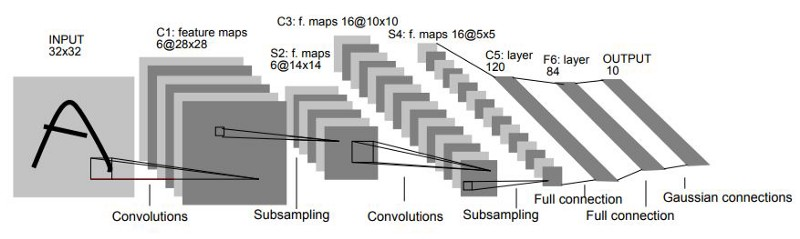

Import necessary packages

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

Load the dataset

In [2]:
dataset_name='CIFAR10'
if dataset_name=='CIFAR10':
  training_data=datasets.CIFAR10(root='./data',train=True,download=True,transform=transforms.ToTensor())
  train_dataloader= DataLoader(training_data,batch_size=32, shuffle=True)
  test_data= datasets.CIFAR10(root='./data',train=False,download=True,transform=transforms.ToTensor())
  test_dataloader=DataLoader(test_data,batch_size=32,shuffle=True)
elif dataset_name=='MNIST':
  training_data=datasets.MNIST(root='./data',train=True,download=True,transform=transforms.ToTensor())
  train_dataloader= DataLoader(training_data,batch_size=32, shuffle=True)
  test_data= datasets.MNIST(root='./data',train=False,download=True,transform=transforms.ToTensor())
  test_dataloader=DataLoader(test_data,batch_size=32,shuffle=True)
else:
  print('Provide a valid dataset')



Files already downloaded and verified
Files already downloaded and verified


Classes in the dataset

In [3]:
if dataset_name=='CIFAR10':
  classes={0: 'airplane', 1:'automobile', 2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}
elif dataset_name=='MNIST':
  classes={0: '0', 1:'1', 2:'2',3:'3',4:'4',5:'5',6:'6',7:'7',8:'8',9:'9'}
else:
  print('Provide a valid dataset')


Display some sample images of the dataset

(32, 32, 32, 3)


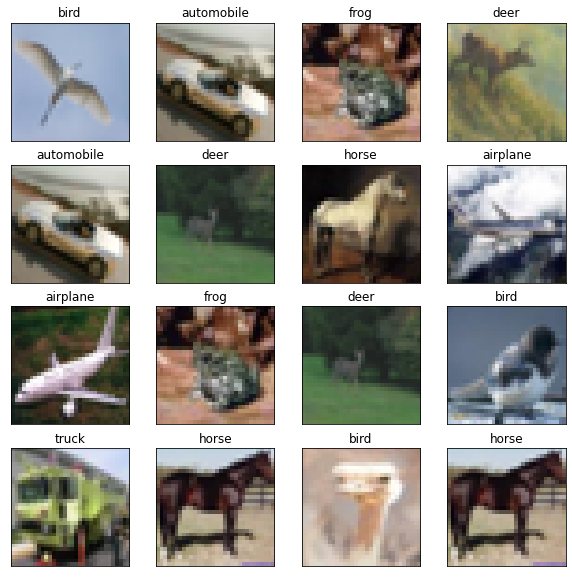

In [4]:
num_images=16
images,labels=next(iter(train_dataloader))
labels=labels.numpy()
img_numpy=images.numpy()
img=np.swapaxes(img_numpy,1,-1)
img=np.swapaxes(img,1,2)
print(img.shape)
batch_size=images.shape[0]
img_indices=np.random.randint(0,batch_size,num_images)
plt.figure(figsize=(10,10))
for i, img_indx in enumerate(img_indices):
  plt.subplot(4,4,i+1)
  if dataset_name=='MNIST':
    plt.imshow(np.squeeze(img[img_indx]))
  else:
    plt.imshow(img[img_indx])
  plt.xticks([])
  plt.yticks([])
  plt.title(classes[labels[img_indx]])
plt.show()

Select the device CUDA or CPU

In [5]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
# class LeNet(nn.Module):
#   def __init__(self):
#     super(LeNet,self).__init__()
#     self.lenet_layers=nn.Sequential(nn.Conv2d(in_channels=3,out_channels=6,kernel_size=(5,5),stride=(1,1)), #28 x 28
#                                       nn.ReLU(),
#                                       nn.MaxPool2d(kernel_size=(2,2)), # 14 x 14
#                                       nn.Conv2d(in_channels=6,out_channels=16,kernel_size=(5,5),stride=(1,1)), # 10 x 10
#                                       nn.ReLU(),
#                                       nn.MaxPool2d(kernel_size=(2,2)), # 5 x 5
#                                       nn.Flatten(),
#                                       nn.Linear(400,120),
#                                       nn.ReLU(),
#                                       nn.Linear(120,84),
#                                       nn.ReLU(),
#                                       nn.Linear(84,10),
#                                       )

#   def forward(self,x):
#     x=self.lenet_layers(x)
#     return x



Create LeNet Neural Network 

In [7]:
class LeNet(nn.Module):
  def __init__(self,in_channels,flatten_dim):
    super(LeNet,self).__init__()

    self.conv1=nn.Conv2d(in_channels=in_channels,out_channels=6, kernel_size=(5,5),stride=(1,1))
    self.relu= nn.ReLU()
    self.maxpool=nn.MaxPool2d(kernel_size=(2,2))
    self.conv2=nn.Conv2d(in_channels=6,out_channels=16,kernel_size=(5,5),stride=(1,1))
    self.flatten=nn.Flatten()
    self.fc1=nn.Linear(flatten_dim,120)
    self.fc2=nn.Linear(120,84)
    self.out=nn.Linear(84,10)

  def forward(self,x):
    x=self.conv1(x)
    x=self.relu(x)
    x=self.maxpool(x)

    x=self.conv2(x)
    x=self.relu(x)
    x=self.maxpool(x)

    x=self.flatten(x)

    x=self.fc1(x)
    x=self.relu(x)

    x=self.fc2(x)
    x=self.relu(x)

    x=self.out(x)

    return x

Test the LeNet on random input

In [8]:
if dataset_name=='MNIST':
  in_channels=1
  flatten_dim=256
else:
  in_channels=3
  flatten_dim=400

model=LeNet(in_channels,flatten_dim)
if dataset_name=='MNIST':

  inp=torch.rand(10,1,28,28)
elif dataset_name=='CIFAR10':
  inp=torch.rand(10,3,32,32)
else:
  print('Provide proper dataset')

out=model(inp)
print(f'output shape : {out.shape}')
print(torch.argmax(out,axis=1))

output shape : torch.Size([10, 10])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


Instantiate a model, define loss function and optimizer

In [9]:
# Instantiate a model
model=LeNet(in_channels,flatten_dim).to(device)
# define a optimizer
optimizer=optim.Adam(model.parameters(),lr=1e-3)
# define loss function
criterion=nn.CrossEntropyLoss()

In [10]:
def early_stopping(epoch,test_loss_vec):
  """
  Performs early stopping of the training if the test loss increases between consecutive epochs
  INPUTS: epoch --> current epoch
          test_loss_vect --> history of test loss
  """
  if epoch>0 and test_loss_vec[epoch]> test_loss_vec[epoch-1]:
      return -1
  else:
      return 1


Training loop and also the validation

In [11]:
from torch.types import Device
# Create a training loop
NUM_EPOCHS=10
total_train_batches=len(train_dataloader)
total_test_batches=len(test_dataloader)
total_train_samples=len(train_dataloader.dataset)
total_test_samples=len(test_dataloader.dataset)
train_loss_vec=[]
test_loss_vec= []
for epoch in range(NUM_EPOCHS):
  train_loss=0
  test_loss=0
  train_accuracy=0
  test_accuracy=0
  total_train_loss=0
  total_test_loss=0
  current_train_count=0
  current_test_count=0
  for batch_idx, (train_x,train_y) in enumerate (train_dataloader):
    train_x=train_x.to(device)
    train_y=train_y.to(device)
    prediction=model(train_x)
    pred_label=torch.argmax(prediction,axis=1)
    trainloss=criterion(prediction,train_y)
    optimizer.zero_grad()
    trainloss.backward()
    optimizer.step()
    train_loss+=trainloss.item()
    current_train_count+=(pred_label==train_y).type(torch.float).sum().item()
    total_train_loss=train_loss/total_train_batches
  train_accuracy= current_train_count/total_train_samples
  print(f'epoch # {epoch+1} Train loss: {total_train_loss:.4f} Train Accuracy: {train_accuracy*100:.2f} %')
  train_loss_vec.append(total_train_loss)
  with torch.no_grad():
    for batch_num, (test_x,test_y) in enumerate(test_dataloader):
      test_x=test_x.to(device)
      test_y=test_y.to(device)
      prediction=model(test_x)
      pred_label=torch.argmax(prediction,axis=1)
      testloss= criterion(prediction,test_y)
      test_loss+=testloss.item()
      current_test_count+=(pred_label==test_y).type(torch.float).sum().item()
        
    test_accuracy=current_test_count/total_test_samples
    total_test_loss=test_loss/total_test_batches
    test_loss_vec.append(total_test_loss)
    print(f'epoch #: {epoch+1:02d}/{NUM_EPOCHS}, Val_loss: {test_loss_vec[epoch]:.4f}, Val accuracy: {test_accuracy*100:.2f}')
    flag=early_stopping(epoch,test_loss_vec)
    # if (flag==-1):
    #   break
    # else:
    #   continue


epoch # 1 Train loss: 1.7025 Train Accuracy: 37.27 %
epoch #: 01/10, Val_loss: 1.4833, Val accuracy: 44.83
epoch # 2 Train loss: 1.4304 Train Accuracy: 47.68 %
epoch #: 02/10, Val_loss: 1.3604, Val accuracy: 50.96
epoch # 3 Train loss: 1.3070 Train Accuracy: 52.74 %
epoch #: 03/10, Val_loss: 1.3473, Val accuracy: 52.21
epoch # 4 Train loss: 1.2231 Train Accuracy: 56.05 %
epoch #: 04/10, Val_loss: 1.1985, Val accuracy: 56.95
epoch # 5 Train loss: 1.1614 Train Accuracy: 58.61 %
epoch #: 05/10, Val_loss: 1.1875, Val accuracy: 57.77
epoch # 6 Train loss: 1.1090 Train Accuracy: 60.66 %
epoch #: 06/10, Val_loss: 1.1472, Val accuracy: 59.31
epoch # 7 Train loss: 1.0624 Train Accuracy: 62.36 %
epoch #: 07/10, Val_loss: 1.1158, Val accuracy: 60.35
epoch # 8 Train loss: 1.0232 Train Accuracy: 63.76 %
epoch #: 08/10, Val_loss: 1.1375, Val accuracy: 59.55
epoch # 9 Train loss: 0.9853 Train Accuracy: 65.33 %
epoch #: 09/10, Val_loss: 1.1036, Val accuracy: 60.80
epoch # 10 Train loss: 0.9512 Train A

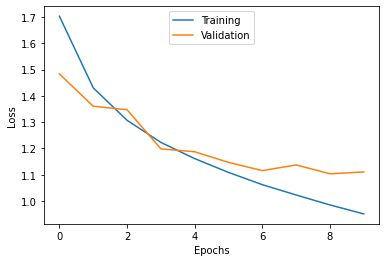

In [12]:
plt.plot(train_loss_vec)
plt.plot(test_loss_vec)
plt.legend(['Training','Validation'], loc='upper center')
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()